# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.3023 | Test Loss 2.3113 | accs Train 0.0833 Test 0.0737


Epoch 100/3000: Train Loss 0.0065 | Test Loss 1.1204 | accs Train 1.0000 Test 0.6590


Epoch 200/3000: Train Loss 0.0028 | Test Loss 1.1635 | accs Train 1.0000 Test 0.6580


Epoch 300/3000: Train Loss 0.0018 | Test Loss 1.1901 | accs Train 1.0000 Test 0.6593


Epoch 400/3000: Train Loss 0.0013 | Test Loss 1.2100 | accs Train 1.0000 Test 0.6592


Epoch 500/3000: Train Loss 0.0010 | Test Loss 1.2259 | accs Train 1.0000 Test 0.6590


Epoch 600/3000: Train Loss 0.0008 | Test Loss 1.2391 | accs Train 1.0000 Test 0.6593


Epoch 700/3000: Train Loss 0.0007 | Test Loss 1.2504 | accs Train 1.0000 Test 0.6597


Epoch 800/3000: Train Loss 0.0006 | Test Loss 1.2602 | accs Train 1.0000 Test 0.6600


Epoch 900/3000: Train Loss 0.0005 | Test Loss 1.2687 | accs Train 1.0000 Test 0.6600


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.2764 | accs Train 1.0000 Test 0.6601


Epoch 1100/3000: Train Loss 0.0004 | Test Loss 1.2832 | accs Train 1.0000 Test 0.6602


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.2894 | accs Train 1.0000 Test 0.6599


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.2950 | accs Train 1.0000 Test 0.6599


Epoch 1400/3000: Train Loss 0.0003 | Test Loss 1.3001 | accs Train 1.0000 Test 0.6600


Epoch 1500/3000: Train Loss 0.0003 | Test Loss 1.3048 | accs Train 1.0000 Test 0.6602


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.3091 | accs Train 1.0000 Test 0.6607


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.3132 | accs Train 1.0000 Test 0.6607


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.3169 | accs Train 1.0000 Test 0.6612


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.3204 | accs Train 1.0000 Test 0.6612


Epoch 2000/3000: Train Loss 0.0002 | Test Loss 1.3236 | accs Train 1.0000 Test 0.6609


Epoch 2100/3000: Train Loss 0.0002 | Test Loss 1.3266 | accs Train 1.0000 Test 0.6609


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.3293 | accs Train 1.0000 Test 0.6607


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.3320 | accs Train 1.0000 Test 0.6611


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.3344 | accs Train 1.0000 Test 0.6611


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.3367 | accs Train 1.0000 Test 0.6612


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.3388 | accs Train 1.0000 Test 0.6614


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.3409 | accs Train 1.0000 Test 0.6618


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.3428 | accs Train 1.0000 Test 0.6618


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.3446 | accs Train 1.0000 Test 0.6618


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.3463 | accs Train 1.0000 Test 0.6619
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3046 | Test Loss 2.3113 | accs Train 0.0733 Test 0.0718


Epoch 100/3000: Train Loss 0.1454 | Test Loss 0.4573 | accs Train 0.9733 Test 0.8666


Epoch 200/3000: Train Loss 0.0292 | Test Loss 0.4941 | accs Train 1.0000 Test 0.8677


Epoch 300/3000: Train Loss 0.0127 | Test Loss 0.5314 | accs Train 1.0000 Test 0.8678


Epoch 400/3000: Train Loss 0.0076 | Test Loss 0.5575 | accs Train 1.0000 Test 0.8689


Epoch 500/3000: Train Loss 0.0053 | Test Loss 0.5771 | accs Train 1.0000 Test 0.8697


Epoch 600/3000: Train Loss 0.0040 | Test Loss 0.5926 | accs Train 1.0000 Test 0.8693


Epoch 700/3000: Train Loss 0.0032 | Test Loss 0.6054 | accs Train 1.0000 Test 0.8698


Epoch 800/3000: Train Loss 0.0026 | Test Loss 0.6162 | accs Train 1.0000 Test 0.8699


Epoch 900/3000: Train Loss 0.0022 | Test Loss 0.6254 | accs Train 1.0000 Test 0.8693


Epoch 1000/3000: Train Loss 0.0019 | Test Loss 0.6335 | accs Train 1.0000 Test 0.8696


Epoch 1100/3000: Train Loss 0.0017 | Test Loss 0.6407 | accs Train 1.0000 Test 0.8694


Epoch 1200/3000: Train Loss 0.0015 | Test Loss 0.6470 | accs Train 1.0000 Test 0.8702


Epoch 1300/3000: Train Loss 0.0014 | Test Loss 0.6528 | accs Train 1.0000 Test 0.8700


Epoch 1400/3000: Train Loss 0.0013 | Test Loss 0.6580 | accs Train 1.0000 Test 0.8698


Epoch 1500/3000: Train Loss 0.0012 | Test Loss 0.6627 | accs Train 1.0000 Test 0.8699


Epoch 1600/3000: Train Loss 0.0011 | Test Loss 0.6671 | accs Train 1.0000 Test 0.8698


Epoch 1700/3000: Train Loss 0.0010 | Test Loss 0.6711 | accs Train 1.0000 Test 0.8696


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.6748 | accs Train 1.0000 Test 0.8696


Epoch 1900/3000: Train Loss 0.0009 | Test Loss 0.6782 | accs Train 1.0000 Test 0.8695


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.6814 | accs Train 1.0000 Test 0.8696


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6844 | accs Train 1.0000 Test 0.8697


Epoch 2200/3000: Train Loss 0.0008 | Test Loss 0.6872 | accs Train 1.0000 Test 0.8700


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.6898 | accs Train 1.0000 Test 0.8701


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.6922 | accs Train 1.0000 Test 0.8700


Epoch 2500/3000: Train Loss 0.0007 | Test Loss 0.6945 | accs Train 1.0000 Test 0.8702


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.6967 | accs Train 1.0000 Test 0.8704


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.6987 | accs Train 1.0000 Test 0.8705


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.7006 | accs Train 1.0000 Test 0.8705


Epoch 2900/3000: Train Loss 0.0006 | Test Loss 0.7024 | accs Train 1.0000 Test 0.8703


Epoch 3000/3000: Train Loss 0.0005 | Test Loss 0.7041 | accs Train 1.0000 Test 0.8702
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3081 | Test Loss 2.3113 | accs Train 0.0720 Test 0.0714


Epoch 100/3000: Train Loss 0.3059 | Test Loss 0.3681 | accs Train 0.9125 Test 0.8895


Epoch 200/3000: Train Loss 0.1421 | Test Loss 0.3276 | accs Train 0.9645 Test 0.9054


Epoch 300/3000: Train Loss 0.0685 | Test Loss 0.3339 | accs Train 0.9885 Test 0.9080


Epoch 400/3000: Train Loss 0.0357 | Test Loss 0.3500 | accs Train 0.9990 Test 0.9079


Epoch 500/3000: Train Loss 0.0215 | Test Loss 0.3659 | accs Train 0.9990 Test 0.9074


Epoch 600/3000: Train Loss 0.0145 | Test Loss 0.3796 | accs Train 0.9995 Test 0.9080


Epoch 700/3000: Train Loss 0.0106 | Test Loss 0.3912 | accs Train 1.0000 Test 0.9075


Epoch 800/3000: Train Loss 0.0081 | Test Loss 0.4010 | accs Train 1.0000 Test 0.9072


Epoch 900/3000: Train Loss 0.0065 | Test Loss 0.4094 | accs Train 1.0000 Test 0.9074


Epoch 1000/3000: Train Loss 0.0054 | Test Loss 0.4168 | accs Train 1.0000 Test 0.9076


Epoch 1100/3000: Train Loss 0.0046 | Test Loss 0.4232 | accs Train 1.0000 Test 0.9075


Epoch 1200/3000: Train Loss 0.0040 | Test Loss 0.4289 | accs Train 1.0000 Test 0.9077


Epoch 1300/3000: Train Loss 0.0035 | Test Loss 0.4340 | accs Train 1.0000 Test 0.9081


Epoch 1400/3000: Train Loss 0.0031 | Test Loss 0.4386 | accs Train 1.0000 Test 0.9081


Epoch 1500/3000: Train Loss 0.0028 | Test Loss 0.4427 | accs Train 1.0000 Test 0.9082


Epoch 1600/3000: Train Loss 0.0025 | Test Loss 0.4465 | accs Train 1.0000 Test 0.9080


Epoch 1700/3000: Train Loss 0.0023 | Test Loss 0.4500 | accs Train 1.0000 Test 0.9081


Epoch 1800/3000: Train Loss 0.0021 | Test Loss 0.4532 | accs Train 1.0000 Test 0.9080


Epoch 1900/3000: Train Loss 0.0020 | Test Loss 0.4561 | accs Train 1.0000 Test 0.9077


Epoch 2000/3000: Train Loss 0.0019 | Test Loss 0.4588 | accs Train 1.0000 Test 0.9074


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.4613 | accs Train 1.0000 Test 0.9075


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.4637 | accs Train 1.0000 Test 0.9076


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.4659 | accs Train 1.0000 Test 0.9080


Epoch 2400/3000: Train Loss 0.0015 | Test Loss 0.4679 | accs Train 1.0000 Test 0.9082


Epoch 2500/3000: Train Loss 0.0014 | Test Loss 0.4698 | accs Train 1.0000 Test 0.9082


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.4716 | accs Train 1.0000 Test 0.9083


Epoch 2700/3000: Train Loss 0.0013 | Test Loss 0.4732 | accs Train 1.0000 Test 0.9082


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.4748 | accs Train 1.0000 Test 0.9083


Epoch 2900/3000: Train Loss 0.0012 | Test Loss 0.4763 | accs Train 1.0000 Test 0.9084


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.4777 | accs Train 1.0000 Test 0.9085
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3138 | Test Loss 2.3112 | accs Train 0.0735 Test 0.0711


Epoch 100/3000: Train Loss 0.3339 | Test Loss 0.3516 | accs Train 0.9030 Test 0.8972


Epoch 200/3000: Train Loss 0.2227 | Test Loss 0.2814 | accs Train 0.9353 Test 0.9192


Epoch 300/3000: Train Loss 0.1618 | Test Loss 0.2533 | accs Train 0.9537 Test 0.9297


Epoch 400/3000: Train Loss 0.1182 | Test Loss 0.2379 | accs Train 0.9693 Test 0.9325


Epoch 500/3000: Train Loss 0.0862 | Test Loss 0.2292 | accs Train 0.9802 Test 0.9349


Epoch 600/3000: Train Loss 0.0630 | Test Loss 0.2249 | accs Train 0.9885 Test 0.9369


Epoch 700/3000: Train Loss 0.0463 | Test Loss 0.2232 | accs Train 0.9935 Test 0.9378


Epoch 800/3000: Train Loss 0.0342 | Test Loss 0.2234 | accs Train 0.9957 Test 0.9389


Epoch 900/3000: Train Loss 0.0258 | Test Loss 0.2247 | accs Train 0.9978 Test 0.9391


Epoch 1000/3000: Train Loss 0.0199 | Test Loss 0.2267 | accs Train 0.9988 Test 0.9392


Epoch 1100/3000: Train Loss 0.0158 | Test Loss 0.2290 | accs Train 0.9992 Test 0.9403


Epoch 1200/3000: Train Loss 0.0128 | Test Loss 0.2315 | accs Train 0.9993 Test 0.9413


Epoch 1300/3000: Train Loss 0.0106 | Test Loss 0.2341 | accs Train 0.9995 Test 0.9414


Epoch 1400/3000: Train Loss 0.0090 | Test Loss 0.2366 | accs Train 0.9998 Test 0.9417


Epoch 1500/3000: Train Loss 0.0077 | Test Loss 0.2390 | accs Train 1.0000 Test 0.9426


Epoch 1600/3000: Train Loss 0.0067 | Test Loss 0.2413 | accs Train 1.0000 Test 0.9430


Epoch 1700/3000: Train Loss 0.0059 | Test Loss 0.2434 | accs Train 1.0000 Test 0.9429


Epoch 1800/3000: Train Loss 0.0053 | Test Loss 0.2454 | accs Train 1.0000 Test 0.9430


Epoch 1900/3000: Train Loss 0.0048 | Test Loss 0.2473 | accs Train 1.0000 Test 0.9432


Epoch 2000/3000: Train Loss 0.0043 | Test Loss 0.2490 | accs Train 1.0000 Test 0.9433


Epoch 2100/3000: Train Loss 0.0040 | Test Loss 0.2507 | accs Train 1.0000 Test 0.9435


Epoch 2200/3000: Train Loss 0.0037 | Test Loss 0.2522 | accs Train 1.0000 Test 0.9436


Epoch 2300/3000: Train Loss 0.0034 | Test Loss 0.2536 | accs Train 1.0000 Test 0.9434


Epoch 2400/3000: Train Loss 0.0032 | Test Loss 0.2550 | accs Train 1.0000 Test 0.9436


Epoch 2500/3000: Train Loss 0.0030 | Test Loss 0.2562 | accs Train 1.0000 Test 0.9436


Epoch 2600/3000: Train Loss 0.0028 | Test Loss 0.2574 | accs Train 1.0000 Test 0.9436


Epoch 2700/3000: Train Loss 0.0026 | Test Loss 0.2585 | accs Train 1.0000 Test 0.9435


Epoch 2800/3000: Train Loss 0.0025 | Test Loss 0.2596 | accs Train 1.0000 Test 0.9436


Epoch 2900/3000: Train Loss 0.0023 | Test Loss 0.2606 | accs Train 1.0000 Test 0.9437


Epoch 3000/3000: Train Loss 0.0022 | Test Loss 0.2615 | accs Train 1.0000 Test 0.9436
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3138 | Test Loss 2.3112 | accs Train 0.0768 Test 0.0713


Epoch 100/3000: Train Loss 0.3527 | Test Loss 0.3478 | accs Train 0.8985 Test 0.8974


Epoch 200/3000: Train Loss 0.2590 | Test Loss 0.2685 | accs Train 0.9254 Test 0.9219


Epoch 300/3000: Train Loss 0.2109 | Test Loss 0.2300 | accs Train 0.9413 Test 0.9328


Epoch 400/3000: Train Loss 0.1762 | Test Loss 0.2020 | accs Train 0.9508 Test 0.9402


Epoch 500/3000: Train Loss 0.1494 | Test Loss 0.1807 | accs Train 0.9588 Test 0.9460


Epoch 600/3000: Train Loss 0.1277 | Test Loss 0.1643 | accs Train 0.9654 Test 0.9505


Epoch 700/3000: Train Loss 0.1096 | Test Loss 0.1515 | accs Train 0.9710 Test 0.9531


Epoch 800/3000: Train Loss 0.0942 | Test Loss 0.1415 | accs Train 0.9752 Test 0.9562


Epoch 900/3000: Train Loss 0.0810 | Test Loss 0.1335 | accs Train 0.9799 Test 0.9583


Epoch 1000/3000: Train Loss 0.0697 | Test Loss 0.1273 | accs Train 0.9837 Test 0.9606


Epoch 1100/3000: Train Loss 0.0598 | Test Loss 0.1224 | accs Train 0.9861 Test 0.9629


Epoch 1200/3000: Train Loss 0.0513 | Test Loss 0.1185 | accs Train 0.9884 Test 0.9641


Epoch 1300/3000: Train Loss 0.0440 | Test Loss 0.1154 | accs Train 0.9906 Test 0.9647


Epoch 1400/3000: Train Loss 0.0378 | Test Loss 0.1131 | accs Train 0.9926 Test 0.9654


Epoch 1500/3000: Train Loss 0.0325 | Test Loss 0.1113 | accs Train 0.9939 Test 0.9658


Epoch 1600/3000: Train Loss 0.0281 | Test Loss 0.1100 | accs Train 0.9956 Test 0.9664


Epoch 1700/3000: Train Loss 0.0243 | Test Loss 0.1092 | accs Train 0.9967 Test 0.9668


Epoch 1800/3000: Train Loss 0.0211 | Test Loss 0.1088 | accs Train 0.9975 Test 0.9671


Epoch 1900/3000: Train Loss 0.0185 | Test Loss 0.1086 | accs Train 0.9980 Test 0.9674


Epoch 2000/3000: Train Loss 0.0163 | Test Loss 0.1087 | accs Train 0.9985 Test 0.9679


Epoch 2100/3000: Train Loss 0.0144 | Test Loss 0.1089 | accs Train 0.9991 Test 0.9677


Epoch 2200/3000: Train Loss 0.0129 | Test Loss 0.1092 | accs Train 0.9992 Test 0.9678


Epoch 2300/3000: Train Loss 0.0116 | Test Loss 0.1096 | accs Train 0.9996 Test 0.9680


Epoch 2400/3000: Train Loss 0.0105 | Test Loss 0.1101 | accs Train 0.9997 Test 0.9682


Epoch 2500/3000: Train Loss 0.0095 | Test Loss 0.1106 | accs Train 0.9997 Test 0.9684


Epoch 2600/3000: Train Loss 0.0086 | Test Loss 0.1111 | accs Train 0.9998 Test 0.9683


Epoch 2700/3000: Train Loss 0.0079 | Test Loss 0.1116 | accs Train 0.9998 Test 0.9683


Epoch 2800/3000: Train Loss 0.0073 | Test Loss 0.1121 | accs Train 0.9999 Test 0.9685


Epoch 2900/3000: Train Loss 0.0068 | Test Loss 0.1126 | accs Train 0.9999 Test 0.9685


Epoch 3000/3000: Train Loss 0.0063 | Test Loss 0.1131 | accs Train 0.9999 Test 0.9687
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3137 | Test Loss 2.3112 | accs Train 0.0759 Test 0.0713


Epoch 100/3000: Train Loss 0.3620 | Test Loss 0.3459 | accs Train 0.8957 Test 0.8998


Epoch 200/3000: Train Loss 0.2729 | Test Loss 0.2645 | accs Train 0.9214 Test 0.9232


Epoch 300/3000: Train Loss 0.2272 | Test Loss 0.2240 | accs Train 0.9349 Test 0.9348


Epoch 400/3000: Train Loss 0.1937 | Test Loss 0.1935 | accs Train 0.9443 Test 0.9440


Epoch 500/3000: Train Loss 0.1678 | Test Loss 0.1699 | accs Train 0.9517 Test 0.9493


Epoch 600/3000: Train Loss 0.1473 | Test Loss 0.1518 | accs Train 0.9574 Test 0.9546


Epoch 700/3000: Train Loss 0.1305 | Test Loss 0.1375 | accs Train 0.9623 Test 0.9585


Epoch 800/3000: Train Loss 0.1166 | Test Loss 0.1259 | accs Train 0.9667 Test 0.9619


Epoch 900/3000: Train Loss 0.1047 | Test Loss 0.1165 | accs Train 0.9701 Test 0.9646


Epoch 1000/3000: Train Loss 0.0946 | Test Loss 0.1089 | accs Train 0.9734 Test 0.9663


Epoch 1100/3000: Train Loss 0.0859 | Test Loss 0.1025 | accs Train 0.9759 Test 0.9677


Epoch 1200/3000: Train Loss 0.0783 | Test Loss 0.0971 | accs Train 0.9782 Test 0.9703


Epoch 1300/3000: Train Loss 0.0717 | Test Loss 0.0926 | accs Train 0.9801 Test 0.9722


Epoch 1400/3000: Train Loss 0.0658 | Test Loss 0.0888 | accs Train 0.9819 Test 0.9727


Epoch 1500/3000: Train Loss 0.0606 | Test Loss 0.0855 | accs Train 0.9836 Test 0.9735


Epoch 1600/3000: Train Loss 0.0559 | Test Loss 0.0827 | accs Train 0.9855 Test 0.9742


Epoch 1700/3000: Train Loss 0.0517 | Test Loss 0.0803 | accs Train 0.9869 Test 0.9754


Epoch 1800/3000: Train Loss 0.0479 | Test Loss 0.0782 | accs Train 0.9880 Test 0.9763


Epoch 1900/3000: Train Loss 0.0444 | Test Loss 0.0763 | accs Train 0.9891 Test 0.9768


Epoch 2000/3000: Train Loss 0.0413 | Test Loss 0.0748 | accs Train 0.9900 Test 0.9771


Epoch 2100/3000: Train Loss 0.0385 | Test Loss 0.0734 | accs Train 0.9909 Test 0.9778


Epoch 2200/3000: Train Loss 0.0359 | Test Loss 0.0723 | accs Train 0.9916 Test 0.9780


Epoch 2300/3000: Train Loss 0.0335 | Test Loss 0.0713 | accs Train 0.9923 Test 0.9780


Epoch 2400/3000: Train Loss 0.0313 | Test Loss 0.0704 | accs Train 0.9930 Test 0.9779


Epoch 2500/3000: Train Loss 0.0293 | Test Loss 0.0697 | accs Train 0.9936 Test 0.9783


Epoch 2600/3000: Train Loss 0.0274 | Test Loss 0.0691 | accs Train 0.9941 Test 0.9784


Epoch 2700/3000: Train Loss 0.0257 | Test Loss 0.0686 | accs Train 0.9946 Test 0.9786


Epoch 2800/3000: Train Loss 0.0242 | Test Loss 0.0681 | accs Train 0.9952 Test 0.9787


Epoch 2900/3000: Train Loss 0.0227 | Test Loss 0.0678 | accs Train 0.9956 Test 0.9786


Epoch 3000/3000: Train Loss 0.0214 | Test Loss 0.0675 | accs Train 0.9960 Test 0.9788
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.3463 | accs: 0.6619
 540 samples | Test Loss: 0.7041 | accs: 0.8702
1940 samples | Test Loss: 0.4777 | accs: 0.9085
5940 samples | Test Loss: 0.2615 | accs: 0.9436
19940 samples | Test Loss: 0.1131 | accs: 0.9687
59940 samples | Test Loss: 0.0675 | accs: 0.9788

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0009 | accs: 1.0000
 Model 5940 | Train Loss: 0.0023 | accs: 1.0000
 Model 19940 | Train Loss: 0.0034 | accs: 1.0000
 Model 59940 | Train Loss: 0.0072 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.2787 | accs: 0.6983
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0010 | accs: 1.0000
 Model 5940 | Train Loss: 0.0021 | accs: 1.0000
 Model 19940 | Train Loss: 0.0051 | accs: 1.0000
 Model 59940 | Trai

 Model 1940 | Train Loss: 0.4803 | accs: 0.9098
 Model 5940 | Train Loss: 0.2702 | accs: 0.9445


 Model 19940 | Train Loss: 0.0853 | accs: 0.9777
 Model 59940 | Train Loss: 0.0214 | accs: 0.9960


### Model + Data Specific Verification

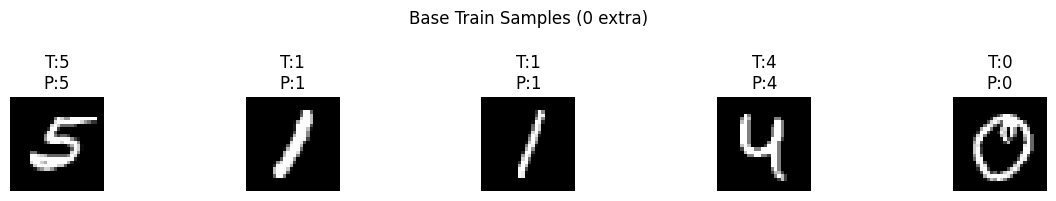

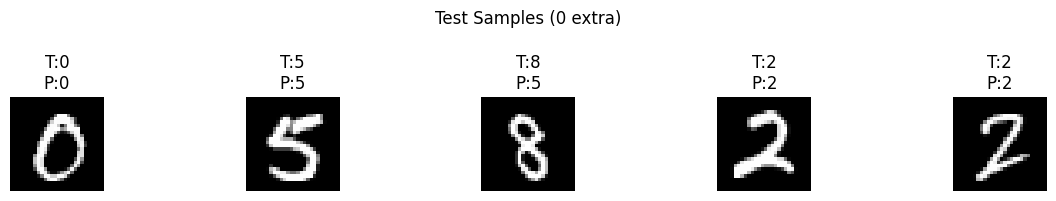

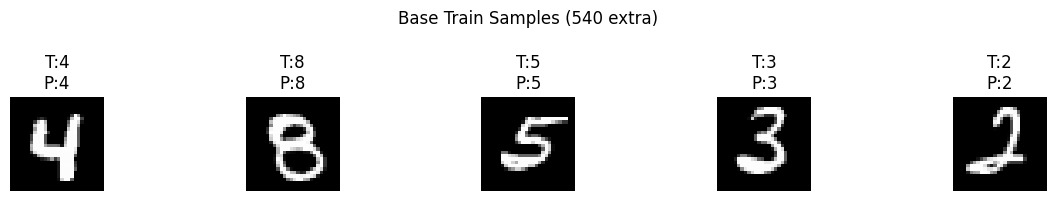

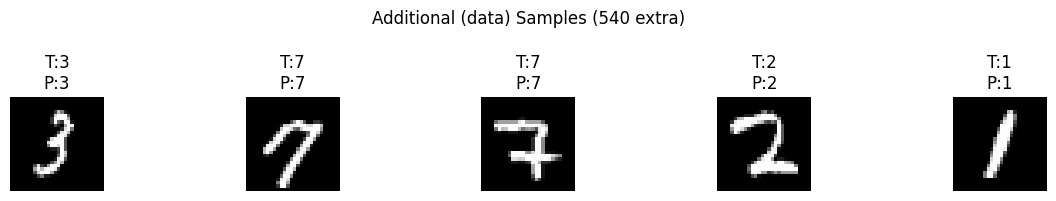

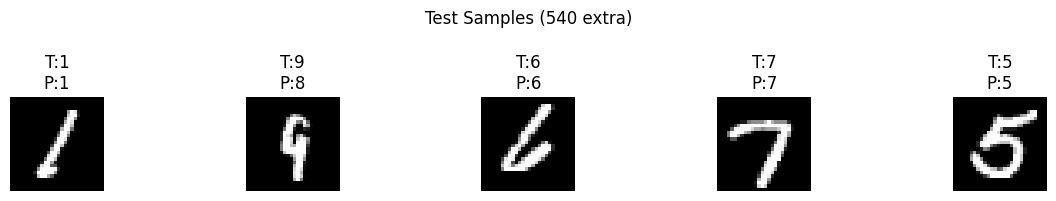

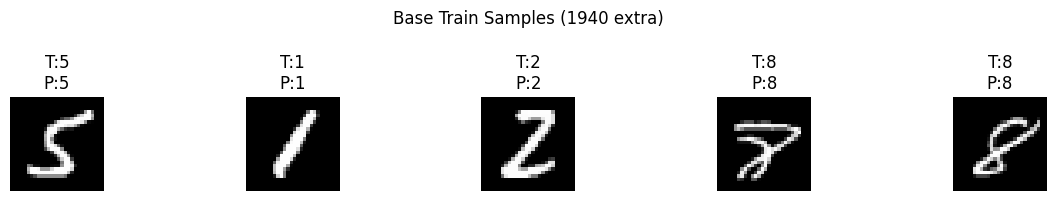

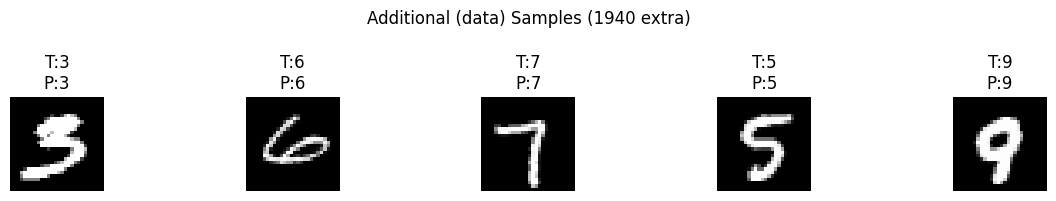

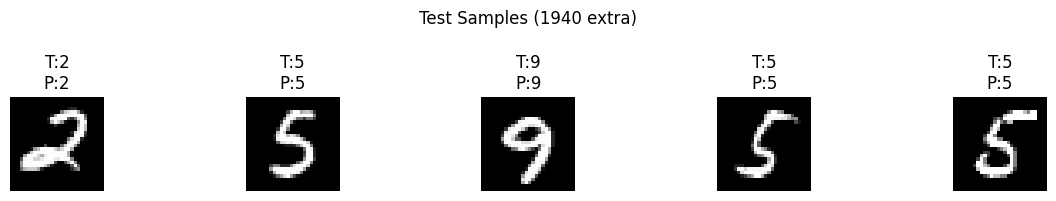

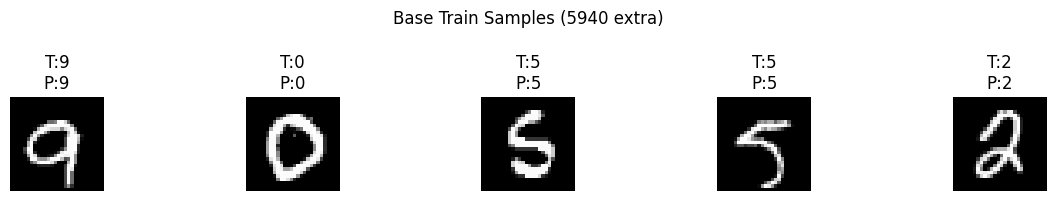

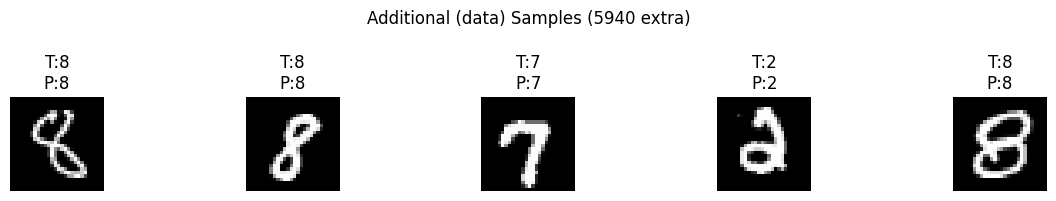

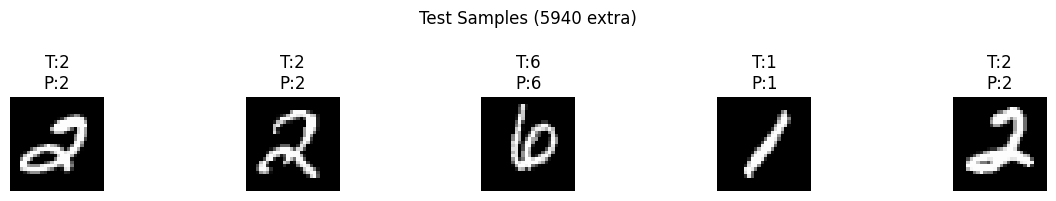

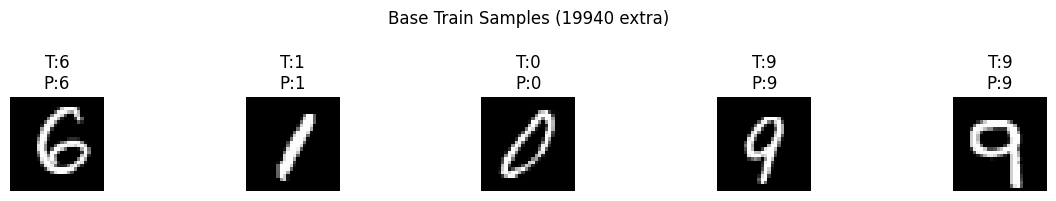

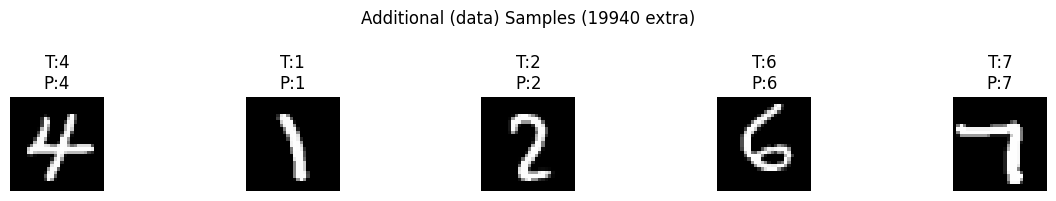

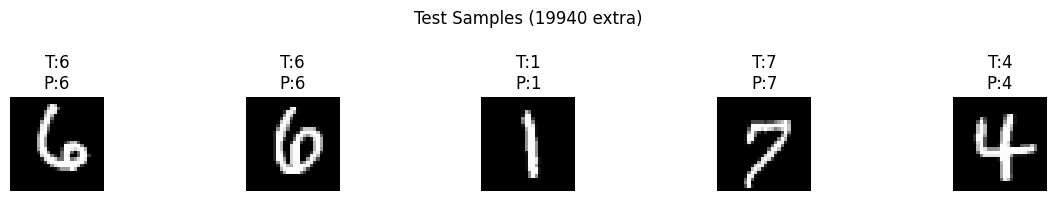

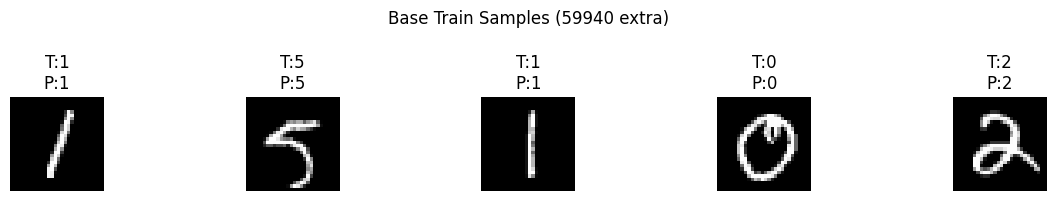

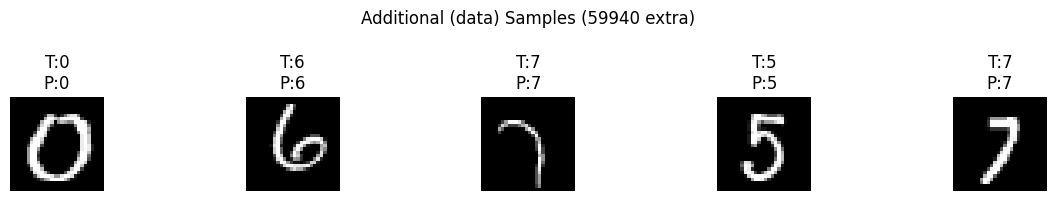

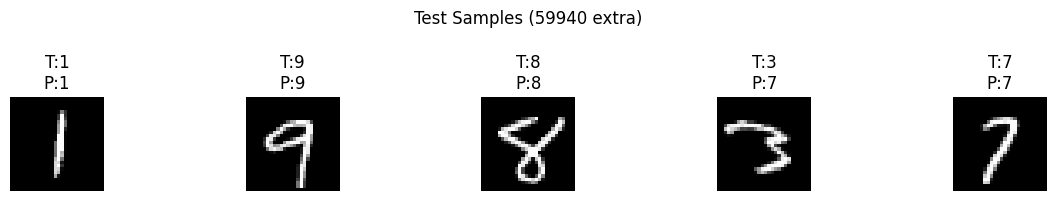

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
